In [1]:
import pandas as pd
from openai import OpenAI
from pydantic import BaseModel, ValidationError
import pandas as pd
import json
import time

In [2]:
from dotenv import load_dotenv

load_dotenv() 

True

In [3]:
raw = pd.read_parquet('data/501c3_charity_geocoded_missions_clean.parquet', engine='pyarrow')

In [10]:
missions = raw.CANONICAL_MISSION.dropna().tolist()
missions_subset = missions[0:3_000]

In [11]:
len(missions_subset)

3000

In [12]:
from openai import OpenAI
import openai  # for specific exception types
from pydantic import BaseModel, ValidationError
import pandas as pd
import json
import time
import os

client = OpenAI()

classifier_prompt = '''You are classifying nonprofit mission statements as RELIGIOUS (1) or NON-RELIGIOUS (0).

Use these definitions, which reflect the preferences of my organization:

- Label 1 (RELIGIOUS) if:
  - The mission mentions religion, faith, God, Christ, Jesus, Bible, gospel, church, ministry, spiritual growth, or similar concepts; OR
  - The mission is very general but strongly emphasizes community betterment, compassion, serving the poor, or moral uplift,
    in a way typical of faith-based charities. Examples: "community betterment", "help the poor", "serve our neighbors",
    "acts of compassion", "uplift our community", etc.

- Label 0 (NON-RELIGIOUS) if:
  - The mission clearly focuses on secular activities (healthcare, sports, arts, environment, economic development,
    education, fairs, libraries, recreation, etc.) and does not show an obviously religious or faith-based motivation.

Examples (mission → label):

- "community betterment" → 1
- "to provide weekend food for children in need" → 1
- "religious services" → 1
- "to provide soccer instruction to hanover township youth" → 0
- "operate rural public library" → 0
- "the bangor symphony orchestra provides powerful enriching and diverse musical experiences" → 0

Now classify the following mission:

MISSION: "{mission_text}"

Respond ONLY in this exact JSON format:
{{"label": 0 or 1, "reason": "short explanation"}}
'''

class MissionLabel(BaseModel):
    label: int | None
    reason: str

output_path = "classified_missions_gpt4omini.csv"
checkpoint_every = 100  # save every 100 items
max_retries = 5

# ----- Optional: resume from existing file -----
results = []
start_index = 0

if os.path.exists(output_path):
    existing_df = pd.read_csv(output_path)
    results = existing_df.to_dict(orient="records")
    start_index = len(existing_df)
    print(f"Resuming from index {start_index}, already have {start_index} rows.")

# assume missions_subset is your full list of mission strings
total = len(missions_subset)

for i in range(start_index, total):
    mission = missions_subset[i]
    prompt = classifier_prompt.format(mission_text=mission)

    # retry loop
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a careful JSON-only classifier."},
                    {"role": "user", "content": prompt},
                ],
                response_format={"type": "json_object"},
                temperature=0,
            )

            raw_output = response.choices[0].message.content.strip()

            # Parse JSON + validate with Pydantic
            try:
                data = json.loads(raw_output)
                structured = MissionLabel(**data)
            except (json.JSONDecodeError, ValidationError):
                print(f"[Warning] Malformed output on item {i}, keeping raw text.")
                structured = MissionLabel(label=None, reason=raw_output)

            results.append({
                "mission": mission,
                "label": structured.label,
                "reason": structured.reason,
            })

            print(f"[{i+1}/{total}] {mission[:50]}... → {structured.label}")

            # small sleep to be nice to the API
            time.sleep(0.2)
            break  # success, exit retry loop

        except openai.RateLimitError as e:
            # backoff and retry
            wait = 2 ** attempt  # 1,2,4,8,16...
            print(f"[Rate limit] item {i+1}, attempt {attempt+1}/{max_retries}, waiting {wait}s")
            time.sleep(wait)
        except Exception as e:
            # other errors: log, store, and move on
            print(f"[Error on item {i+1}] {e}")
            results.append({"mission": mission, "label": None, "reason": str(e)})
            break  # don't retry non-rate-limit errors

    # checkpointing: save every N items
    if (i + 1) % checkpoint_every == 0 or (i + 1) == total:
        df = pd.DataFrame(results)
        df.to_csv(output_path, index=False)
        print(f"Checkpoint saved at {i+1} items → {output_path}")

# final save (in case last chunk < checkpoint_every)
df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print("✅ Finished. Final results saved.")



Resuming from index 2, already have 2 rows.
[3/3000] the bangor symphony orchestra provides powerful en... → 0
[4/3000] henrietta d goodall hospital inc owns and operates... → 0
[5/3000] this corporation hancock county agricultural socie... → 0
[6/3000] to provide exceptional healthcare services in a sa... → 0
[7/3000] to promote and sponsor argricultural education in ... → 0
[8/3000] community betterment... → 1
[9/3000] operate rural public library... → 0
[10/3000] to provide affordable quality recreation programs ... → 0
[11/3000] - to establish operate & maintain for scientific c... → 0
[12/3000] waldo county general hospital's mission is to be t... → 0
[13/3000] excellent health care provided with compassion and... → 0
[14/3000] conduct of agricultural fair to educate the genera... → 0
[15/3000] promote economic development in windsor vt through... → 0
[16/3000] mission:... → 0
[17/3000] plan organize and manage the northern maine agricu... → 0
[18/3000] the iris network helps peop

In [13]:
results

[{'mission': 'provide soccer instruction to hanover township youth',
  'label': 0,
  'reason': 'The mission focuses on providing soccer instruction, which is a secular activity and does not indicate any religious motivation.'},
 {'mission': "the organization's primary exempt purpose is to teach youngsters the basics of sailing seaman-ship and safe conduct on the water it is the organization's mission to create and sustain a community of families who enjoy being on the water",
  'label': 0,
  'reason': 'The mission focuses on teaching sailing and creating a community around water activities, which are secular in nature.'},
 {'mission': 'the bangor symphony orchestra provides powerful enriching and diverse musical experiences through live concert performances and education programs of the highest quality',
  'label': 0,
  'reason': 'The mission focuses on providing musical experiences and education, which are secular activities.'},
 {'mission': 'henrietta d goodall hospital inc owns and 

In [43]:
import pandas as pd
df = pd.read_csv('classified_missions_gpt4omini.csv')

In [68]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    #stratify=df['label'],
    random_state=42
)

train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

In [69]:
train_df.shape

(2100, 3)

In [70]:
train_df.label.value_counts()

label
0    1859
1     241
Name: count, dtype: int64

In [71]:
print(train_df["label"].value_counts(normalize=True))   
print(test_df["label"].value_counts(normalize=True))

label
0    0.885238
1    0.114762
Name: proportion, dtype: float64
label
0    0.894444
1    0.105556
Name: proportion, dtype: float64


In [72]:
test_df.shape

(900, 3)

In [73]:
test_df.label.value_counts()

label
0    805
1     95
Name: count, dtype: int64

In [74]:
majority = train_df[train_df.label == 0]
minority = train_df[train_df.label == 1]

# oversample minority to match majority size
minority_upsampled = minority.sample(
    n=len(majority),
    replace=True,
    random_state=42
)

train_balanced = pd.concat([majority, minority_upsampled], ignore_index=True)
train_balanced = train_balanced.sample(frac=1, random_state=42)  # shuffle

train_balanced.to_csv("train_balanced.csv", index=False)

In [75]:
print(train_balanced["label"].value_counts(normalize=True))   
print(test_df["label"].value_counts(normalize=True))

label
0    0.5
1    0.5
Name: proportion, dtype: float64
label
0    0.894444
1    0.105556
Name: proportion, dtype: float64


In [76]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, get_scheduler
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [77]:
data_files = {"train": "train_balanced.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)

Generating train split: 3718 examples [00:00, 110201.70 examples/s]
Generating test split: 900 examples [00:00, 176297.10 examples/s]


In [78]:
print(dataset["train"][0])

{'mission': 'home to home provides monitored child custody exchanges to protect children from potential instances of domestic violence and emtional trauma', 'label': 0, 'reason': 'The mission focuses on providing monitored child custody exchanges and addressing domestic violence, which are secular activities.'}


In [79]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #NOTE: Using base model. Increase size for better performance
sample_text = "The purpose of this organization is to provide community services."
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokens)

{'input_ids': [101, 1996, 3800, 1997, 2023, 3029, 2003, 2000, 3073, 2451, 2578, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [80]:
def tokenize_function(examples):
    return tokenizer(examples["mission"], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets["train"][0])

labels = dataset['train']['label']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
print(class_weights)

Map: 100%|██████████| 900/900 [00:00<00:00, 25611.12 examples/s]

{'mission': 'home to home provides monitored child custody exchanges to protect children from potential instances of domestic violence and emtional trauma', 'label': 0, 'reason': 'The mission focuses on providing monitored child custody exchanges and addressing domestic violence, which are secular activities.', 'input_ids': [101, 2188, 2000, 2188, 3640, 17785, 2775, 9968, 15800, 2000, 4047, 2336, 2013, 4022, 12107, 1997, 4968, 4808, 1998, 7861, 3508, 2389, 12603, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [81]:
dataset

DatasetDict({
    train: Dataset({
        features: ['mission', 'label', 'reason'],
        num_rows: 3718
    })
    test: Dataset({
        features: ['mission', 'label', 'reason'],
        num_rows: 900
    })
})

In [82]:
#label_mapping = {"NON-RELIGIOUS": 0, "RELIGIOUS": 1}
#dataset = dataset.map(lambda x: {"label": label_mapping[x["label"]]})

# Load model with binary classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(model.config)

# Freeze all layers except the classifier
for param in model.bert.parameters():
    param.requires_grad = False

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Trainable parameters: 1538


In [84]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True
)


In [85]:
metric = load('f1') # accuracy does not work great for imbalanced datasets, f1 is better
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    return metric.compute(predictions=predictions, references=labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # This ensures that each batch is dynamically padded to the longest seq. in the batch

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2)) # early stop to reach peak performance and avoid overfitting

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_40310/3241077266.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1
1,No log,0.605835,0.209524
2,No log,0.638863,0.263804
3,0.684700,0.608599,0.292308
4,0.684700,0.637146,0.313725
5,0.670400,0.598006,0.311284
6,0.670400,0.612335,0.321543
7,0.657400,0.617078,0.317365
8,0.657400,0.620216,0.317003
9,0.650900,0.612371,0.323171
10,0.650900,0.620814,0.317280


/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is s

In [86]:
results = trainer.evaluate()
print(results)

/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5980058908462524, 'eval_f1': 0.311284046692607, 'eval_runtime': 9.5696, 'eval_samples_per_second': 94.048, 'eval_steps_per_second': 5.956, 'epoch': 10.0}


/Users/caro/Desktop/GITHUB-REPOS/BINARY-CLASSIFIER-MISSIONS/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0       0.93      0.85      0.89       805
           1       0.25      0.42      0.31        95

    accuracy                           0.80       900
   macro avg       0.59      0.63      0.60       900
weighted avg       0.85      0.80      0.82       900



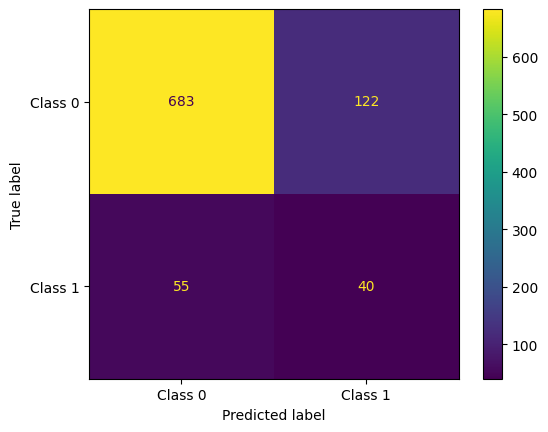

In [87]:
# Generate predictions
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [88]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['mission', 'label', 'reason', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3718
    })
    test: Dataset({
        features: ['mission', 'label', 'reason', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 900
    })
})

In [89]:
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_datasets["test"][idx]["mission"])

Index: 3, Predicted: 0, Actual: 1
committed to providing a holistic learning community which encourages the growth of mind body and spirit and which is actively involved in the local and global community
Index: 7, Predicted: 1, Actual: 0
annual fundraising event held in order to fund organizations that help support the assistance of children with cancer
Index: 11, Predicted: 1, Actual: 0
operating a summer camp
Index: 19, Predicted: 1, Actual: 0
the foundation's primary exempt purpose is to raise funds thru individual donations and thru various fundraising events from which the funds are used to provide assistance to children under the age of 18 who are in need of medical treatment or are indigent
Index: 23, Predicted: 0, Actual: 1
the purpose of taryag legacy foundation inc is to enhance the awareness of children and adults of the importance of the torah and mitzvoth and to educate and encourage its study through the publication of an encyclopedia and torah cards
Index: 38, Predicted:

In [67]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(tokenized_datasets["test"]["mission"][:10])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:

# Visualize explanations
shap.plots.text(shap_values[0])